# <div style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Digit Recognizer (CNN)</div>

<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <b><span style="color:#3E3F4C; font-size:20px; font-family:JetBrains Mono; margin-left: 10px;">
        Competition Description 📜
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Task 🕵
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        See More Here 📈
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        <a href="https://www.kaggle.com/competitions/digit-recognizer/overview">Digit Recognizer</a>
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        This Notebook Covers 📔
    </span></b>
    <ul style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono;  margin-left: 10px; margin-right: 15px; margin-top: 15px; margin-bottom: 20px">
        <li>Simple data augmentation with Scipy.</li>
        <li>Building a CNN architecture which breaks 99.5% of accuracy.</li>
        <li>Implementation of One Cycle Learning Rate Policy Callback.</li>
    </ul>
</blockquote>

In [37]:
# %load ../initial_settings.py
import os
import shutil
import subprocess
import sys
from pathlib import Path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from plotly.subplots import make_subplots
from colorama import Fore, Style
from IPython.display import display_html
from matplotlib.patches import PathPatch

# =============================================================================
# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Here we store models if these are interesting.
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Matplotlib & Seaborn settings.
FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#2a357d", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

# =============================================================================
# Utility functions.
def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


# <div style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Load Data &amp; Augmentation with Scipy</div>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In this section, we load the data and split it in a stratified fashion. In that, we have evenly deployed samples over the training and validation datasets.</li>
        <li>Since it's a small dataset, we can use <code>Scipy</code> for data augmentation (only translations and rotations). You can do this with <code>Tensorflow</code> layers, but these seem to be buggy. See this: <a href="https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting">Tensorflow Data Augmentation gives a warning: Using a while_loop for converting</a>.</li>
    </ul>
</blockquote>


In [38]:
competition = "digit-recognizer"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [39]:
from sklearn.model_selection import train_test_split

X_test = test.values.reshape(-1, 28, 28)

y_train_full = train["label"].values
X_train_full = train.drop("label", axis=1).values.reshape(-1, 28, 28)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

print(f"{CLR}{'Train Shape:':15s}", f"{BLUE}{X_train.shape}{RESET}")
print(f"{CLR}{'Valid Shape:':15s}", f"{BLUE}{X_valid.shape}{RESET}")
print(f"{CLR}{'Test Shape:':15s}", f"{BLUE}{X_test.shape}{RESET}")


Train Shape:    (33600, 28, 28)
Valid Shape:    (8400, 28, 28)
Test Shape:     (28000, 28, 28)


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Let's try to shift and rotate some digits.</li>
    </ul>
</blockquote>

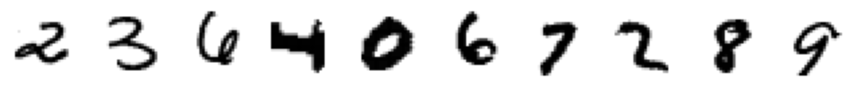

In [40]:
plt.figure(figsize=(12, 2), tight_layout=True, facecolor="white")

for idx, digit in enumerate(X_train[:10]):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(digit, cmap="binary")
    plt.axis("off")
    
plt.show()

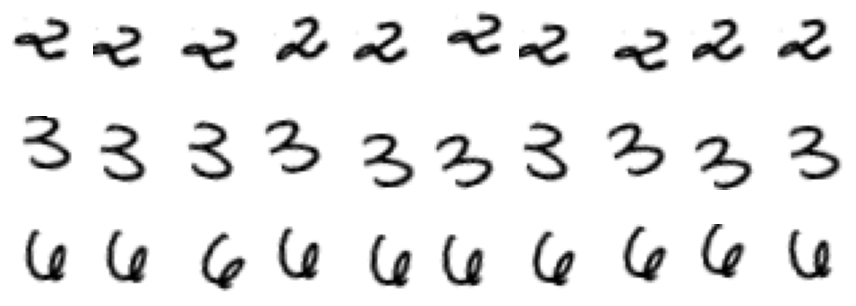

In [41]:
from scipy.ndimage import rotate, shift


plt.figure(figsize=(12, 5), tight_layout=True, facecolor="white")
max_dx, max_dy, max_angle = 4, 4, 20

# Example operations with Scipy.
for row, digit in enumerate(X_train[:3]):
    for col in range(10):
        dx = np.random.randint(-max_dx, max_dx)
        dy = np.random.randint(-max_dy, max_dy)
        angle = np.random.randint(-max_angle, max_angle)

        shifted = shift(digit, (dx, dy))
        rotated = rotate(shifted, angle, order=1, reshape=False)

        plt.subplot(3, 10, (col + 1) + row * 10)
        plt.imshow(rotated, cmap="binary")
        plt.axis("off")

plt.show()


In [42]:
def digits_augmentation(X, y, max_dx=4, max_dy=4, max_angle=20, repeats=3):
    X_augmented = [digit for digit in X]
    y_augmented = [label for label in y]

    for digit, label in zip(X, y):
        for _ in range(repeats):
            dx = np.random.randint(-max_dx, max_dx)
            dy = np.random.randint(-max_dy, max_dy)
            angle = np.random.randint(-max_angle, max_angle)

            shifted = shift(digit, (dx, dy))
            rotated = rotate(shifted, angle, order=1, reshape=False)

            X_augmented.append(rotated)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)


np.random.seed(42)
X_augmented, y_augmented = digits_augmentation(X_train, y_train)

shuffled_ids = np.random.permutation(len(X_augmented))

X_augmented = X_augmented[shuffled_ids]
y_augmented = y_augmented[shuffled_ids]


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The <code>digits_augmentation</code>, by default, performs three repeats of random translations and rotations within one digit. It translates it by <code>(dx, dy)</code> vector, where <code>dx</code> and <code>dy</code> are set by default to 4 (14% of the digit matrix - 28 x 28). It means that digit can be translated maximally by <code>(4, 4)</code>, but usually, it will be shifted by <code>(0, 3)</code>, <code>(-2, 1)</code>, etc.</li>
        <li>Next, we rotate it by degree from the range <code>[-20, 20]</code>.</li>
        <li>Lastly, we need to add one colour channel for <code>CNN</code> and scale matrices as below.</li>
    </ul>
</blockquote>

In [43]:
X_augmented = np.expand_dims(X_augmented, axis=-1) / 255.0
X_train = np.expand_dims(X_train, axis=-1) / 255.0
X_valid = np.expand_dims(X_valid, axis=-1) / 255.0
X_test = np.expand_dims(X_test, axis=-1) / 255.0

print(f"{CLR}{'Augmented Shape:':20s}", f"{BLUE}{X_augmented.shape}{RESET}")
print(f"{CLR}{'Train Shape:':20s}", f"{BLUE}{X_train.shape}{RESET}")
print(f"{CLR}{'Valid Shape:':20s}", f"{BLUE}{X_valid.shape}{RESET}")
print(f"{CLR}{'Test Shape:':20s}", f"{BLUE}{X_test.shape}{RESET}")


Augmented Shape:     (134400, 28, 28, 1)
Train Shape:         (33600, 28, 28, 1)
Valid Shape:         (8400, 28, 28, 1)
Test Shape:          (28000, 28, 28, 1)


# <div style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">CNN with One Cycle Learning Rate Policy</div>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The cyclic learning rate (and also momentum) is an exciting learning rate scheduling technique for faster convergence: <a href="https://arxiv.org/abs/1708.07120">Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</a>.</li>
        <li>The working principle is relatively easy to understand. We start with a given learning rate (usually 10x smaller than the maximum) and allow it to rise to the maximal value (where the solution diverges) roughly by the first half of training. In the second half, the learning rate drops as fast as it grew before, and for the last few epochs, we reduce it such that the final value is roughly 1000x lower than the starting learning rate. On the other hand, the rule with cyclic momentum is inverted. We set the maximum and minimum values of momentum (usually to $0.95$ and $0.85$, respectively), but firstly it falls and then rises.</li>
        <li>There are at least two solutions. One of them is implemented using linear annealing (as depicted above). The second uses cosine annealing, which gives smooth curves. I'll use a cosine one.</li>
        <li>Before we start with One Cycle, we need to write small tools to find the maximal learning rate. To do this, we use <code>ExponentialLearningRate</code> callback that multiplies the optimizer's learning rate by a constant factor at the end of each batch and stores these values. The second thing is the <code>get_lr_vs_loss</code> function which applies this callback over one epoch.</li>
    </ul>
</blockquote>


In [44]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    """For internal use. `ExponentialLearningRate` callback multiplies
    the optimizer's learning rate by a constant factor at the end of each batch."""

    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, lr * self.factor)


def get_lr_vs_loss(model, X, y, batch_size=32, min_lr=1e-4, max_lr=1e-1):
    """For internal use. It takes a given model and performs one learning epoch
    successive increasing learning rate within `ExponentialLearningRate` callback.
    The maximal learning rate appropriate for the One Cycle Learning Rate Policy
    is a value which is located nearly before the divergent solution."""

    init_weights = model.get_weights()

    steps = np.ceil(len(X) / batch_size)
    lr_factor = (max_lr / min_lr) ** (1.0 / steps)
    lr_init = K.get_value(model.optimizer.learning_rate)

    exp_lr = ExponentialLearningRate(lr_factor)
    model.fit(X, y, epochs=1, batch_size=batch_size, callbacks=[exp_lr], verbose=0)

    K.set_value(model.optimizer.learning_rate, lr_init)
    model.set_weights(init_weights)

    return pd.DataFrame(
        {
            "Learning Rate": exp_lr.rates,
            "Loss": exp_lr.losses,
        }
    )


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>As we know, we usually use average pooling layers or max pooling layers in CNNs; nevertheless, I decided to use a depth pooling layer here. This solution isn't so common, but I'm just curious. The point is that max op is performed along the depth dimension, and the network can learn invariance over different features. For example, it can learn invariance to translations and rotations.</li>
    </ul>
</blockquote>

In [45]:
class MaxDepthPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        # The number of channels is stored in shape[-1].
        shape = tf.shape(inputs)
        # Number of channel groups.
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)


In [46]:
np.random.seed(42)

# Kernel size must be a divisor of the number of input maps.
maps = np.random.rand(1, 28, 28, 32)
output = MaxDepthPool2D(pool_size=2)(maps)

print(f"{CLR}{'Maps Shape:':15s}", f"{BLUE}{maps.shape}{RESET}")
print(f"{CLR}{'Output Shape:':15s}", f"{BLUE}{output.shape}{RESET}")


Maps Shape:     (1, 28, 28, 32)
Output Shape:   (1, 28, 28, 16)


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>To build the best possible MNIST CNN, I used clues from this notebook: <a href="https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook">How to choose CNN Architecture MNIST</a>. I encourage you to get familiar with this.</li>
        <li>However, I use several different methods, i.e., activation after batch normalisation, max depth pooling layers and one-cycle learning rate.</li>
    </ul>
</blockquote>

In [47]:
from keras import layers
from functools import partial


DefaultConv2D = partial(
    layers.Conv2D,
    filters=32,
    kernel_size=3,
    strides=1,
    padding="valid",
    use_bias=False,
    kernel_initializer="he_normal",
)

cnn_mnist_model = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=(28, 28, 1)),
        #
        DefaultConv2D(filters=32),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        DefaultConv2D(filters=32),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        MaxDepthPool2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        #
        DefaultConv2D(filters=64, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        DefaultConv2D(filters=64, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        MaxDepthPool2D(pool_size=4),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        #
        layers.Flatten(),
        layers.Dense(128, use_bias=False, kernel_initializer="he_normal"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

cnn_mnist_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"],
)

init_weights = cnn_mnist_model.get_weights()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Since we have CNN architecture, it's time to find maximal learning rate for 1Cycle.</li>
    </ul>
</blockquote>


In [48]:
BATCH_SIZE = 64
lr_vs_loss = get_lr_vs_loss(cnn_mnist_model, X_train, y_train, batch_size=BATCH_SIZE)

fig = px.line(
    lr_vs_loss,
    x="Learning Rate",
    y="Loss",
    height=500,
    width=800,
    log_x=True,
    log_y=True,
    title="CNN with Nadam - Learning Rate vs Loss over One Epoch",
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.show()


525/525 [==============================] - 10s 15ms/step - loss: 0.8944 - accuracy: 0.7196



<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>As you can see, the solution is divergent, nearly the learning rate equal to $0.13$. We need to choose a slightly smaller value, but we cannot overdo it. Let's take $0.04$.</li>
        <li>Now we can handle the 1Cycle implementation. As you can see below, <code>OneCycleLearningRatePolicy</code> takes several parameters:</li>
        <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
            <li><code>max_lr</code> - maximum learning rate (we've just found it).</li>
            <li><code>start_factor</code> - factor by which multiply <code>max_lr</code> at the beginning of training.</li>
            <li><code>final_factor</code> - factor by which multiply <code>max_lr</code> at the final stage of training.</li>
            <li><code>max_momentum</code> - max value of momentum.</li>
            <li><code>min_momentum</code> - min value of momentum.</li>
            <li><code>cycle_momentum</code> - whether cycle momentum or not.</li>
            <li><code>pct_up</code> - percentage value of training time where learning rate rises and momentum drops.</li>
            <li><code>annealing</code> - annealing function (cosine or linear).</li>
        </ul>
        <li>Additionally, I wrote a simple <code>ColoramaVerbose</code> callback which slightly prettifies the training output.</li>
    </ul>
</blockquote>


In [49]:
K = tf.keras.backend


class OneCycleLearningRatePolicy(tf.keras.callbacks.Callback):
    """Implementation of One Cycle Learning Rate Policy - https://arxiv.org/abs/1708.07120."""

    def __init__(
        self,
        max_lr,
        start_factor=1e-1,
        final_factor=1e-4,
        max_momentum=0.95,
        min_momentum=0.85,
        cycle_momentum=False,
        pct_up=0.3,
        annealing="cosine",
    ):
        self.max_lr = max_lr
        self.start_lr = max_lr * start_factor
        self.final_lr = max_lr * final_factor
        self.max_momentum = max_momentum
        self.min_momentum = min_momentum
        self.cycle_momentum = cycle_momentum
        self.pct_up = pct_up
        self.annealing = annealing

        if not annealing in ("cosine", "linear"):
            raise ValueError("Invalid annealing type. Choose 'cosine' or 'linear'.")
        if self.annealing == "cosine":
            self._anneal_func = self._cosine_anneal
        if self.annealing == "linear":
            self._anneal_func = self._linear_anneal

        self.current_step = 0
        self.lr_rates = []
        self.momentum_rates = []

    def on_train_begin(self, logs=None):
        self.total_steps = self.params["steps"] * self.params["epochs"]
        self.steps_up = int(self.total_steps * self.pct_up)
        self.steps_down = self.total_steps - self.steps_up

        if hasattr(self.model.optimizer, "momentum"):
            self.momentum = self.model.optimizer.momentum
        elif hasattr(self.model.optimizer, "beta_1"):
            self.momentum = self.model.optimizer.beta_1
        else:
            raise AttributeError("This optimizer probably does not have momentum.")

    def on_batch_begin(self, batch, logs=None):
        if self.current_step <= self.steps_up:
            pct = self.current_step / self.steps_up
            lr = self._anneal_func(self.start_lr, self.max_lr, pct)
            momentum = self._anneal_func(self.max_momentum, self.min_momentum, pct)
        else:
            pct = (self.current_step - self.steps_up) / self.steps_down
            lr = self._anneal_func(self.max_lr, self.final_lr, pct)
            momentum = self._anneal_func(self.min_momentum, self.max_momentum, pct)

        K.set_value(self.model.optimizer.learning_rate, lr)
        if self.cycle_momentum:
            K.set_value(self.momentum, momentum)

        self.lr_rates.append(lr)
        self.momentum_rates.append(momentum)

        self.current_step += 1

    def _cosine_anneal(self, lr1, lr2, pct):
        return lr2 + (lr1 - lr2) * (np.cos(np.pi * pct) + 1.0) * 0.5

    def _linear_anneal(self, lr1, lr2, pct):
        return lr1 + (lr2 - lr1) * pct


In [50]:
class ColoramaVerbose(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"{CLR}Epoch: {BLUE}{epoch + 1:02d}{CLR} -{RESET}",
            f"{CLR}loss: {BLUE}{logs['loss']:.5f}{CLR} -{RESET}",
            f"{CLR}accuracy: {BLUE}{logs['accuracy']:.5f}{CLR} -{RESET}",
            f"{CLR}val_loss: {BLUE}{logs['val_loss']:.5f}{CLR} -{RESET}",
            f"{CLR}val_accuracy: {BLUE}{logs['val_accuracy']:.5f}",
        )


# <div style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Training &amp; Submission</div>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Obviously, momentum is bugged in <code>Tensorflow 2.11</code>, so we need to turn it off. I figured it out when I called notebook on Kaggle.</li>
        <li>Nevertheless, values are stored anyway to show you how it looks.</li>
    </ul>
</blockquote>

In [51]:
cnn_mnist_model.set_weights(init_weights)
one_cycle_policy = OneCycleLearningRatePolicy(4e-2, cycle_momentum=True)
colorama_verbose = ColoramaVerbose()

history = cnn_mnist_model.fit(
    X_train,  # Without augmentation you can obtain 99.5 too.
    y_train,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid),
    callbacks=[one_cycle_policy, colorama_verbose],
    verbose=0,
)


Epoch: 01 - loss: 0.17266 - accuracy: 0.94902 - val_loss: 0.05767 - val_accuracy: 0.98274
Epoch: 02 - loss: 0.08775 - accuracy: 0.97354 - val_loss: 0.06019 - val_accuracy: 0.98167
Epoch: 03 - loss: 0.08769 - accuracy: 0.97247 - val_loss: 0.07053 - val_accuracy: 0.98119
Epoch: 04 - loss: 0.09338 - accuracy: 0.97107 - val_loss: 0.08064 - val_accuracy: 0.97738
Epoch: 05 - loss: 0.09736 - accuracy: 0.97039 - val_loss: 0.10459 - val_accuracy: 0.97500
Epoch: 06 - loss: 0.10239 - accuracy: 0.97036 - val_loss: 0.07478 - val_accuracy: 0.98071
Epoch: 07 - loss: 0.11466 - accuracy: 0.96783 - val_loss: 0.08353 - val_accuracy: 0.98060
Epoch: 08 - loss: 0.12590 - accuracy: 0.96711 - val_loss: 0.09252 - val_accuracy: 0.98143
Epoch: 09 - loss: 0.12832 - accuracy: 0.96479 - val_loss: 0.06307 - val_accuracy: 0.98619
Epoch: 10 - loss: 0.12191 - accuracy: 0.96774 - val_loss: 0.08800 - val_accuracy: 0.98345
Epoch: 11 - loss: 0.10227 - accuracy: 0.97253 - val_loss: 0.07255 - val_accuracy: 0.98226
Epoch: 12 

In [52]:
valid_loss, valid_accuracy = cnn_mnist_model.evaluate(X_valid, y_valid, verbose=0)

print(f"{CLR}{'Valid Loss:':20s}", f"{BLUE}{valid_loss:.5f}{RESET}")
print(f"{CLR}{'Valid Accuracy:':20s}", f"{BLUE}{valid_accuracy:.5f}{RESET}")


Valid Loss:          0.03116
Valid Accuracy:      0.99381


In [53]:
one_cycle_rates = pd.DataFrame(
    {
        "Step": range(len(one_cycle_policy.lr_rates)),
        "Learning Rate": one_cycle_policy.lr_rates,
        "Momentum Rate": one_cycle_policy.momentum_rates,
    }
)

fig = make_subplots(
    rows=1,
    cols=2,
    x_title="Training Step",
    y_title="Value",
    subplot_titles=("Learning Rate", "Momentum (beta_1) Rate"),
)

fig.add_trace(
    go.Scatter(
        x=one_cycle_rates["Step"],
        y=one_cycle_rates["Learning Rate"],
        name="Learning Rate",
        line=dict(color="#c73c1a"),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=one_cycle_rates["Step"],
        y=one_cycle_rates["Momentum Rate"],
        name="Momentum Rate",
        line=dict(color="#c73c1a"),
    ),
    row=1,
    col=2,
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    height=400,
    width=800,
    title_text="CNN (Nadam) within 1Cycle Policy",
    showlegend=False,
)

fig.show()


In [54]:
results = cnn_mnist_model.predict(X_test, verbose=0).argmax(axis=1)

sumbission = pd.DataFrame({"ImageID": range(1, len(X_test) + 1), "Label": results})
sumbission.set_index("ImageID").to_csv("submission.csv")

sumbission.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #c73c1a">Summary 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>We wrote CNN, which breaks 99.5% accuracy on MNIST.</li>
        <li>We implemented One Cycle Learning Rate Policy.</li>
    </ul>
</blockquote>